## Gaussian Mixture model for cleaner reconstruction results

This notebook is for the development of an additional cleaning step after (or before the reconstruction) to get more precise mapping results. The aim is to write a function that will be include in the tissue reconstruction. The additional step should be optional and given as input into the reconstruct function.

In [1]:
# imports
import anndata
import numpy
%matplotlib inline
import novosparc

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
from scipy.stats import zscore

# Gaussian mixture model
from sklearn.mixture import GaussianMixture

import random
random.seed(0)

In [12]:
# function taken from: https://www.cbrinton.net/ECE20875-2020-Spring/W11/gmms_notebook.pdf
 # Plot function
def plot_mixture(gmm, X, show_legend=True, ax=None):
    if ax is None:
        ax = plt.gca()

    # Compute PDF of whole mixture
    x = np.linspace(-6, 6, 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)

    # Compute PDF for each component
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    # Plot data histogram
    ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4, label
    ='Data')

    # Plot PDF of whole model
    ax.plot(x, pdf, '-k', label='Mixture PDF')

    # Plot PDF of each component
    ax.plot(x, pdf_individual, '--', label='Component PDF')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    ax.set_ylim(0,4)
    ax.set_xlim(-2,2)
    if show_legend:
        ax.legend()

### Test on Drosophila example

In [2]:
sdge = np.genfromtxt("droso_sdge.csv", delimiter=",")

In [3]:
# Reading expression data to scanpy AnnData (cells x genes)
data_dir = '../../novosparc/datasets/drosophila_scRNAseq/'
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()
atlas_dir = '../../novosparc/datasets/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values
locations = locations_apriori

atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

/tmp/ipykernel_37616/2197252676.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


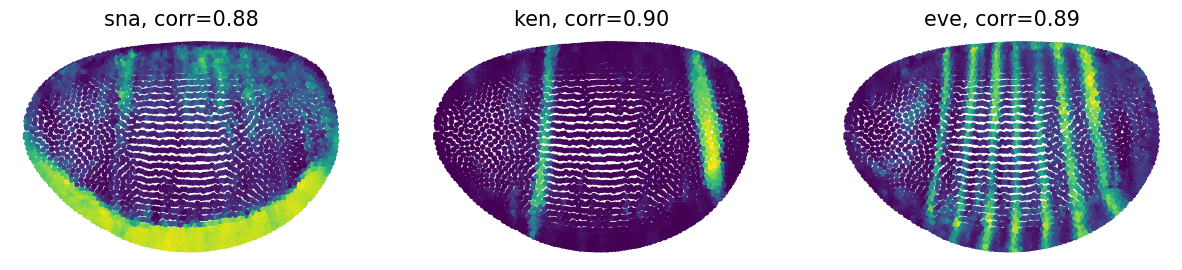

<Figure size 432x288 with 0 Axes>

In [4]:
# test original reconstructed expression of individual genes
pl_genes = ['sna', 'ken', 'eve']
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations

title = ['%s, corr=%.02f' % (g, pearsonr(dataset_reconst[:,g].X.flatten(), atlas[:,g].X.flatten())[0] ) for g in pl_genes]
novosparc.pl.embedding(dataset_reconst, pl_genes, title=title)

## Make a minimal Test set with the three important genes

In [5]:
sdge_test_cols = []
for i, gene in enumerate(pl_genes):
    if gene in dataset_reconst.var_names:
        sdge_test_cols.append(np.asarray(dataset_reconst[:, gene].X).reshape(-1,1))
sdge_test = np.concatenate(sdge_test_cols, axis=1)

In [6]:
sdge_test_names = {'sna':sdge_test[0],
                   'ken':sdge_test[1],
                   'eve':sdge_test[2]}

## Get 2D location matrix per gene

In [12]:
sna_locations = np.asarray(dataset_reconst[:, "sna"].obsm["spatial"])
# numpy.savetxt("droso_sna_2d_locations.csv", sna_locations, delimiter=",")

## Apply Gaussian mixture Model

### single gene example

In [7]:
# sdge = 8924 (genes) x 3039 (locations)
# concatenate two different genes to get a test for having multiple distributions on 1 gene
# sdge_small = np.concatenate((sdge.T[:,1789], sdge.T[:,3])) # this results in two distributions of # equal size

# only gene sna
sdge_small = sdge_test[:,0].reshape(-1,1)

# other test versions
# sdge_small = np.concatenate((sdge.T[:,1789], sdge.T[:,3], sdge.T[:,90])) # I wanted to have one dist more locations than the other - but doing it like this results in only having one label again?
# sdge_small = sdge.T[:,367] # it can happen that there is only 1 distribution but the label is 1 not 0?

sdge_small

array([[0.00044545],
       [0.0007145 ],
       [0.00049097],
       ...,
       [0.00178861],
       [0.00195639],
       [0.00027624]], dtype=float32)

## Normalize data

In [8]:
# min-max
# sdge_small_normed = (sdge_small - np.min(sdge_small))/ (np.max(sdge_small) - np.min(sdge_small))
sdge_small_normed = zscore(sdge_small)

In [9]:
# # apply model
# gmm = GaussianMixture(n_components=2).fit(sdge_small.reshape(-1,1))
# # gmm = GaussianMixture(n_components=2).fit(sdge_small)
# # get label for distributions
# labels = gmm.predict(sdge_small.reshape(-1,1))
# # labels = gmm.predict(sdge_small)
# labels

Initialization 0
  Iteration 10
Initialization converged: True
True
True
[[-0.46767795]
 [ 1.73403   ]]


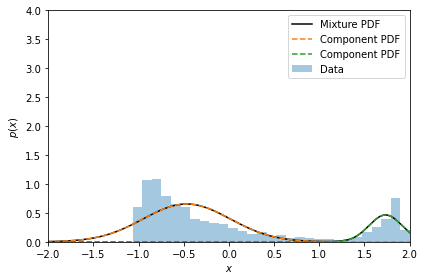

In [18]:
# apply model
gmm = GaussianMixture(n_components=2, verbose=1).fit(sdge_small_normed.reshape(-1,1))
# # get label for distributions
labels = gmm.predict(sdge_small_normed.reshape(-1,1))
print(0 in labels)
print(1 in labels)
# count locations per distribution
pd.Series(labels).value_counts()
print(gmm.means_)

# plot
plot_mixture(gmm, sdge_small_normed)
plt.tight_layout()

### check function parts manually

In [13]:
tmp = gmm.score_samples

(array([0.60628075, 1.06332316, 1.08508647, 0.78971954, 0.65913599,
        0.60938988, 0.39485966, 0.36687758, 0.32024056, 0.30158577,
        0.23940313, 0.18032963, 0.14302007, 0.16167482, 0.10260136,
        0.11192875, 0.06840091, 0.09016478, 0.05907351, 0.05285524,
        0.05596438, 0.03730958, 0.04352785, 0.09016483, 0.16478381,
        0.26116709, 0.39485977, 0.75862822, 0.20520272, 0.03109132]),
 array([-1.0645126 , -0.9586774 , -0.8528422 , -0.74700695, -0.64117175,
        -0.53533655, -0.42950135, -0.32366613, -0.21783093, -0.11199571,
        -0.0061605 ,  0.09967472,  0.20550993,  0.31134513,  0.41718036,
         0.52301556,  0.62885076,  0.73468596,  0.8405212 ,  0.9463564 ,
         1.0521916 ,  1.1580268 ,  1.263862  ,  1.3696972 ,  1.4755324 ,
         1.5813677 ,  1.6872029 ,  1.7930381 ,  1.8988733 ,  2.0047085 ,
         2.1105437 ], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7f7d56f1e7f0>])

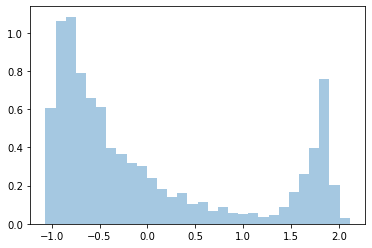

In [14]:
ax = plt.gca()
ax.hist(sdge_small_normed, 30, density=True, histtype='stepfilled', alpha=0.4, label
='Data')

In [15]:
x = np.linspace(-1, 1, 100)
logprob = gmm.score_samples(x.reshape(-1, 1))
pdf = np.exp(logprob)

(array([23.,  8.,  6.,  4.,  4.,  7.,  8.,  8., 10., 22.]),
 array([0.0063194 , 0.07104915, 0.1357789 , 0.20050865, 0.2652384 ,
        0.32996815, 0.3946979 , 0.45942765, 0.52415741, 0.58888716,
        0.65361691]),
 <BarContainer object of 10 artists>)

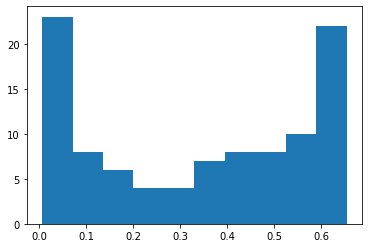

In [16]:
plt.hist(pdf)

## plot fitted model

below just simulated data to see how the plot function works.
also taken from : https://www.cbrinton.net/ECE20875-2020-Spring/W11/gmms_notebook.pdf

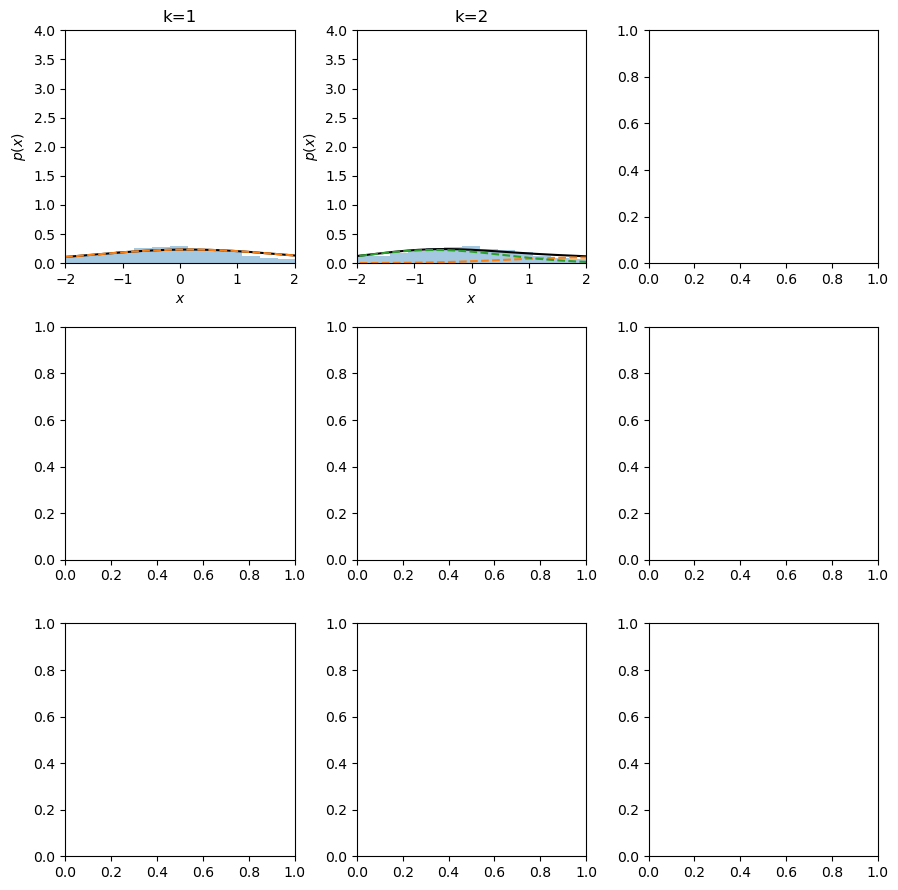

In [39]:
rng = np.random.RandomState(seed=1)
X = np.concatenate([rng.normal(-1, 1.5, 350),
 rng.normal(0, 1, 500),
 rng.normal(3, 0.5, 150)]).reshape(-1, 1)
# Fit models with 1-10 components
k_arr = np.arange(2) + 1
models = [
 GaussianMixture(n_components=k).fit(X)
 for k in k_arr
]

# Show all models for n_components 1 to 9
_, axes = plt.subplots(3, 3, figsize=np.array([3,3])*3, dpi=100)
for gmm, ax in zip(models, axes.ravel()):

    plot_mixture(gmm, X, show_legend=False, ax=ax)
    ax.set_title(f'k={gmm.n_components}')
plt.tight_layout()

(array([886., 662., 348., 232., 131.,  87.,  54.,  55., 264., 320.]),
 array([2.4179947e-06, 2.1052135e-04, 4.1862470e-04, 6.2672806e-04,
        8.3483139e-04, 1.0429347e-03, 1.2510380e-03, 1.4591415e-03,
        1.6672448e-03, 1.8753482e-03, 2.0834515e-03], dtype=float32),
 <BarContainer object of 10 artists>)

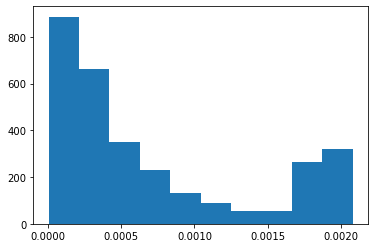

In [22]:
plt.hist(sdge_small)

In [23]:
# test version for only 1 gene

# merge labels column with original expression value column
label_assignment = np.concatenate((sdge_small.reshape(-1,1),
                                   labels.reshape(-1,1)), axis=1)

# check how many labels and how many values per label
vl_cnts = pd.Series(labels).value_counts()

# TODO I would like to write this stuff without those magic numbers
# only apply sorting when 2 distributions where modelled
if len(vl_cnts) > 1:
   # when the 0 dist is the dist of choice, labels have to be inverted for multiplication
    if vl_cnts[0] > vl_cnts[1]:
        # invert labels
        label_assignment[:,1] = np.logical_not(label_assignment[:,1]).astype(int)
    # multiply expression values with label values so that the 0 dist values are effectively removed
    label_assignment[:,0] *= label_assignment[:,1]

sdge_modded = label_assignment[:,0]


In [24]:
sdge_modded

array([0.00044545, 0.0007145 , 0.00049097, ..., 0.00178861, 0.00195639,
       0.00027624])

### do it in a loop for the whole matrix
in order to get a new matix full with updated columns.

In [21]:

sdge_test_normed_minmax = (sdge_test - np.min(sdge_test))/ (np.max(sdge_test) - np.min(sdge_test))

sdge_modded_cols = []
for column in sdge_test_normed_minmax.T:
    # apply model
    gmm = GaussianMixture(n_components=2).fit(column.reshape(-1,1))
    # get labels< for distributions
    labels = gmm.predict(column.reshape(-1,1))

    # merge labels column with original expression value column
    label_assignment = np.concatenate((column.reshape(-1,1),
                                   labels.reshape(-1,1)), axis=1)

    # check how many labels and how many values per label
    vl_cnts = pd.Series(labels).value_counts()

    # TODO I would like to write this stuff without those magic numbers
    # only apply sorting when 2 distributions where modelled
    if len(vl_cnts) > 1:
        # when the 0 dist is the dist of choice, labels have to be inverted for multiplication
        if vl_cnts[0] < vl_cnts[1]:
            # invert labels
            label_assignment[:,1] = np.logical_not(label_assignment[:,1]).astype(int)
        # multiply expression values with label values so that the 0 dist values are effectively removed
        label_assignment[:,0] *= label_assignment[:,1]

    # build a list of modified columns
    sdge_modded_cols.append(label_assignment[:,0].reshape(-1,1))

sdge_modded_minmax = np.concatenate(sdge_modded_cols, axis=1)

In [30]:
sdge_test_normed_log = np.log(sdge_test)

sdge_modded_cols = []

for column in sdge_test_normed_log.T:
    # apply model
    gmm = GaussianMixture(n_components=2).fit(column.reshape(-1,1))
    # get labels< for distributions
    labels = gmm.predict(column.reshape(-1,1))

    # merge labels column with original expression value column
    label_assignment = np.concatenate((column.reshape(-1,1),
                                   labels.reshape(-1,1)), axis=1)

    # check how many labels and how many values per label
    vl_cnts = pd.Series(labels).value_counts()

    # TODO I would like to write this stuff without those magic numbers
    # only apply sorting when 2 distributions where modelled
    if len(vl_cnts) > 1:
        # when the 0 dist is the dist of choice, labels have to be inverted for multiplication
        if vl_cnts[0] < vl_cnts[1]:
            # invert labels
            label_assignment[:,1] = np.logical_not(label_assignment[:,1]).astype(int)
        # multiply expression values with label values so that the 0 dist values are effectively removed
        label_assignment[:,0] *= label_assignment[:,1]

    # build a list of modified columns
    sdge_modded_cols.append(label_assignment[:,0].reshape(-1,1))

sdge_modded_log = np.concatenate(sdge_modded_cols, axis=1)*-1
sdge_modded_log[:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [20]:
%%time
sdge_normed_zscore = zscore(sdge)

sdge_modded_cols = []

for column in sdge_normed_zscore.T:
    # apply model
    gmm = GaussianMixture(n_components=2).fit(column.reshape(-1,1))
    # get labels< for distributions
    labels = gmm.predict(column.reshape(-1,1))

    # merge labels column with original expression value column
    label_assignment = np.concatenate((column.reshape(-1,1),
                                   labels.reshape(-1,1)), axis=1)

    # check how many labels and how many values per label
    vl_cnts = pd.Series(labels).value_counts()

    # TODO I would like to write this stuff without those magic numbers
    # only apply sorting when 2 distributions where modelled
    if len(vl_cnts) > 1:
        # when the 0 dist is the dist of choice, labels have to be inverted for multiplication
        if vl_cnts[0] < vl_cnts[1]:
            # invert labels
            label_assignment[:,1] = np.logical_not(label_assignment[:,1]).astype(int)
        # multiply expression values with label values so that the 0 dist values are effectively removed
        label_assignment[:,0] *= label_assignment[:,1]

    # build a list of modified columns
    sdge_modded_cols.append(label_assignment[:,0].reshape(-1,1))

sdge_modded_zscore = np.concatenate(sdge_modded_cols, axis=1)

/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/sklearn/mixture/_base.py:286: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


CPU times: user 31min 12s, sys: 51min 57s, total: 1h 23min 10s
Wall time: 20min 13s


## test it

/tmp/ipykernel_37616/49084349.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_test = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_37616/49084349.py:6: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_cleaned_zscore = sc.AnnData(pd.DataFrame(sdge_modded_zscore.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib

original


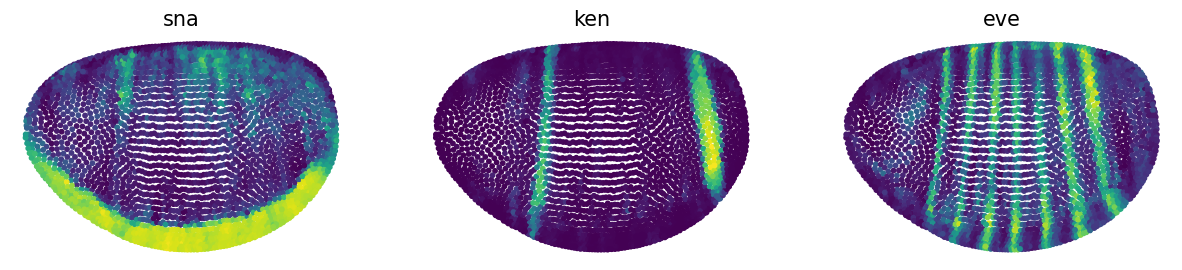

zscore


<Figure size 432x288 with 0 Axes>

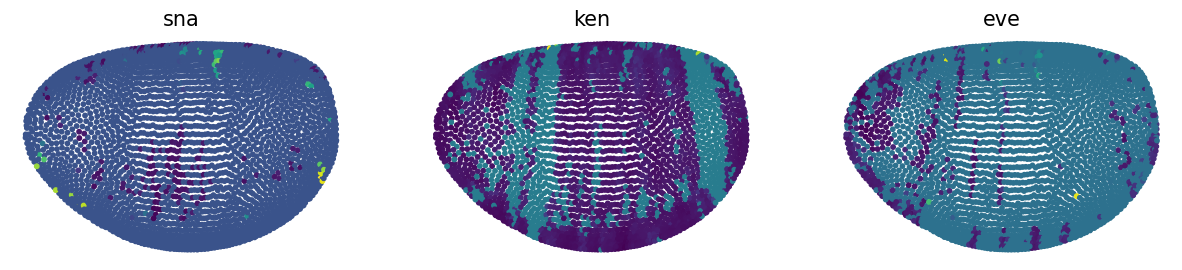

<Figure size 432x288 with 0 Axes>

In [27]:
one_gene = ['sna']
dataset_test = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
# test cleaned reconstructed expression of individual genes
# dataset_cleaned_minmax = sc.AnnData(pd.DataFrame(sdge_modded_minmax, columns=pl_genes))
# dataset_cleaned_log = sc.AnnData(pd.DataFrame(sdge_modded_log, columns=pl_genes))
dataset_cleaned_zscore = sc.AnnData(pd.DataFrame(sdge_modded_zscore.T, columns=gene_names))

#dataset_small = sc.AnnData(pd.DataFrame(sdge_small, columns=one_gene))
# dataset_cleaned_minmax.obsm['spatial'] = locations
# dataset_cleaned_log.obsm['spatial'] = locations
dataset_cleaned_zscore.obsm['spatial'] = locations
dataset_test.obsm['spatial'] = locations
#dataset_small.obsm['spatial'] = locations

# plot
print("original")
novosparc.pl.embedding(dataset_test, pl_genes)
# print("normalized minmax")
# novosparc.pl.embedding(dataset_cleaned_minmax, pl_genes)
# print("normalized log transformed")
# novosparc.pl.embedding(dataset_cleaned_log, pl_genes)
print("zscore")
novosparc.pl.embedding(dataset_cleaned_zscore, pl_genes)